# Countries

- Data Cleaning
- Descriptive Statistics
- Grouping by Proxies
- Selecting Specific Items

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [2]:
# Reading the data from countries revisions countries items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/countries_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/countries.csv')

In [3]:
print("Number of Revisions in Countries Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Countries Dataset")
print(items.shape)

Number of Revisions in Countries Dataset
(3503629, 12)
Number of Wikidata Items in Countries Dataset
(673486, 3)


# Data Cleaning

In [4]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [5]:
# Method to assign edit types to each revision by using the revision comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # c = comment.decode("utf-8").lower()
    
    # Converting the comment to lowercase
    c = comment.lower()
    edit_type = '' 
    
    if c == '':
        return edit_type
    
    if "|" in c:
        # Comments which have |
        # Extracting initial edit summary and removing /*
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            edit_type = 'undo'
            return edit_type
        elif 'restore' in cc:
            edit_type = 'restore'
            return edit_type
        elif 'wbsetclaimvalue' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbsetlabeldescriptionaliases' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbcreateredirect' in cc:
            edit_type = 'create'
            return edit_type
        elif 'merge' in cc:
            edit_type = 'merge'
            return edit_type
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                edit_type = 'create'
                return edit_type
            elif 'add' in ccc:
                edit_type = 'add'
                return edit_type
            elif 'set' in ccc:
                edit_type = 'set'
                return edit_type
            elif 'update' in ccc:
                edit_type = 'update'
                return edit_type
            elif 'remove' in ccc:
                edit_type = 'remove'
                return edit_type
    if 'revert' in c: 
        edit_type = 'revert'
        return edit_type  
    elif 'protect' in c:
        edit_type = 'protect'
        return edit_type  
    elif 'undid' in c:
        edit_type = 'undo'
        return edit_type      
    return edit_type
        

In [6]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [7]:
rev.shape

(3503629, 9)

In [8]:
# Removing revisions with empty types - empty comments or edge cases
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [9]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [10]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    # Remove preceeding b from storing as a bytes object
    # Replace ' with empty character
    u = user[1:].replace("'", "")
    
    user_type = ''
    
    if u == "":
        user_type = 'Anonymous'
        return user_type
    elif u in bots.values:
        user_type = 'Bot'
        return user_type
    else: 
        user_type = 'Registered'
        return user_type
    return user_type
    

In [11]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [12]:
# Need to recalculate editcount for the items
# Drop old editscount column
rev = rev.drop(['editscount'], axis=1)

In [13]:
editscount = rev['qid'].value_counts()

In [14]:
editscount.describe()

count    671581.000000
mean          5.190891
std          12.548644
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         657.000000
Name: qid, dtype: float64

In [15]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [16]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
253204
Items with No of Edits = 2
211409
Items with No of Edits = 3
58056
Items with No of Edits = 4
22926
Items with No of Edits = 5
25572
Items with No of Edits <= 5
571167


In [17]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [18]:
df_editscount.shape

(100414, 2)

In [19]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [20]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [21]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [22]:
print(df_editscount.head())
print(rev[rev['qid'] == 'Q4115189'])
print(rev[rev['qid'] == 'Q52'])
print(rev[rev['qid'] == 'Q2013'])

      qid  editscount
0   Q1085         657
1    Q649         468
2    Q656         413
3  Q14960         279
4  Q34600         201
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []


In [23]:
print("Number of Revisions in Countries Dataset after Data Cleaning")
print(rev.shape)
print("Number of Wikidata Items in Countries Dataset after Data Cleaning")
countries_items = rev['qid'].value_counts()
print(countries_items.shape)

Number of Revisions in Countries Dataset after Data Cleaning
(2416350, 10)
Number of Wikidata Items in Countries Dataset after Data Cleaning
(100414,)


# Descriptive Statistics

In [24]:
print(countries_items.describe().astype(int))

count    100414
mean         24
std          25
min           6
25%           7
50%           9
75%          60
max         657
Name: qid, dtype: int32


In [25]:
# Converting a series to a dataframe
c_items = pd.DataFrame({'type':countries_items.index, 'count':countries_items.values})

In [26]:
# Items between the median and 75th percentile
print(c_items[(c_items['count'] >= 9) & (c_items['count'] < 60)])
# Items in the top 25% of the dataset
print(c_items[c_items['count'] >= 60])
# Items below median that is items that fall in the fist 50%
print(c_items[c_items['count'] < 9])
# Items that form the low 25% of the dataset
print(c_items[c_items['count'] < 7])
# Items that are part of 75% of the dataset
print(c_items[c_items['count'] < 60])

            type  count
25409    Q910670     59
25410    Q959560     59
25411   Q1161622     59
25412    Q158247     59
25413    Q660134     59
...          ...    ...
50412    Q271925      9
50413    Q163423      9
50414  Q27194645      9
50415  Q27903995      9
50416  Q19421430      9

[25008 rows x 2 columns]
          type  count
0        Q1085    657
1         Q649    468
2         Q656    413
3       Q14960    279
4       Q34600    201
...        ...    ...
25404  Q865090     60
25405  Q238434     60
25406   Q83242     60
25407   Q11131     60
25408  Q990524     60

[25409 rows x 2 columns]
             type  count
50417    Q3069604      8
50418    Q3490598      8
50419     Q499770      8
50420    Q3175626      8
50421    Q2197104      8
...           ...    ...
100409   Q2031037      6
100410   Q7993664      6
100411  Q20131814      6
100412   Q6882392      6
100413    Q997245      6

[49997 rows x 2 columns]
             type  count
81088   Q20229845      6
81089     Q960083   

# Statistics for Proxies

In [27]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [28]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

           count
type            
add      1886149
update    264110
create    161238
remove     81298
set        20631
undo        1590
merge        730
revert       397
restore      203
protect        4


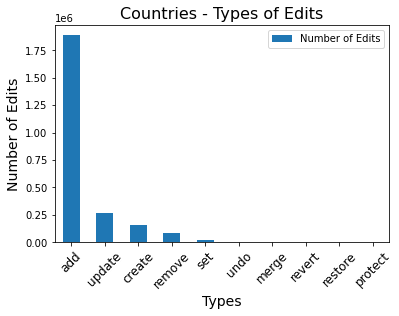

In [30]:
# Plotting the statistics for the proxies in the dataset
ax = ts.plot.bar()

plt.title('Countries - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [31]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

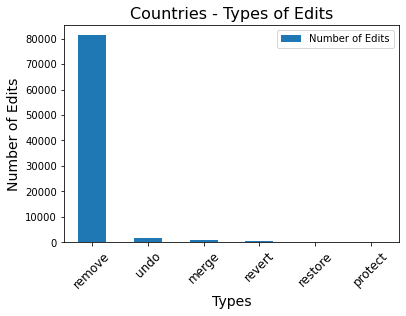

In [32]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Countries - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [33]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
undo      1590
merge      730
revert     397
restore    203
protect      4


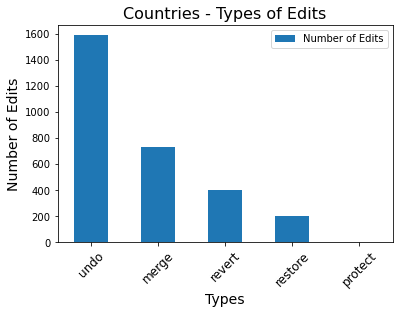

In [34]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Countries - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

# Statistics for No of Edits

In [35]:
no_of_edits = countries_items.to_numpy()

(array([5.8170e+04, 1.1493e+04, 3.7040e+03, 6.8800e+02, 1.9300e+02,
        1.5300e+02, 1.4100e+02, 3.1100e+02, 1.1725e+04, 1.2966e+04,
        7.0000e+01, 2.0000e+02, 4.1700e+02, 9.8000e+01, 2.0000e+01,
        1.1000e+01, 6.0000e+00, 2.0000e+01, 7.0000e+00, 7.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

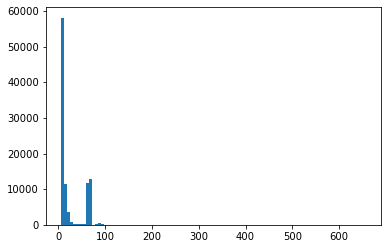

In [37]:
# Exploring distribution of number of edits
plt.hist(no_of_edits, 100)

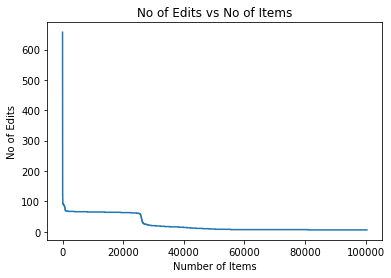

In [38]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Grouping by Proxies

In [39]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [40]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [41]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [42]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [43]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [44]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [45]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [46]:
proxies = proxies.reset_index()

In [47]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [48]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [49]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [50]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe  
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [51]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [52]:
proxies

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
0,Q2123546,0,0,0,0,0,0,6,3
1,Q2123580,0,0,0,0,0,0,7,3
2,Q2123765,0,0,0,0,0,0,8,5
3,Q2123937,0,0,0,0,0,0,6,4
4,Q2124144,0,0,0,0,0,0,7,4
...,...,...,...,...,...,...,...,...,...
100409,Q28088282,0,0,0,0,0,0,16,2
100410,Q28088799,0,0,0,0,0,0,11,1
100411,Q28088874,0,0,0,0,0,0,10,1
100412,Q28089276,0,0,0,0,0,0,6,1


In [53]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,100414.000000,100414.000000,100414.000000,100414.000000,100414.000000,100414.000000,100414.000000,100414.000000
mean,0.003954,0.007270,0.015834,0.002022,0.000040,0.809628,24.063876,2.408907
std,0.089894,0.087038,0.162049,0.055436,0.006311,2.122363,25.062927,1.788717
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,3.000000
max,7.000000,3.000000,8.000000,4.000000,1.000000,137.000000,657.000000,51.000000


Text(0, 0.5, 'No of Edits')

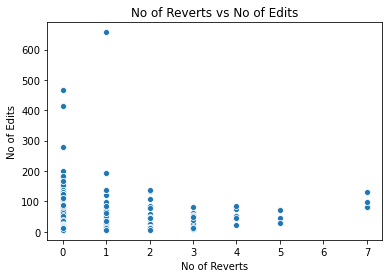

In [54]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")

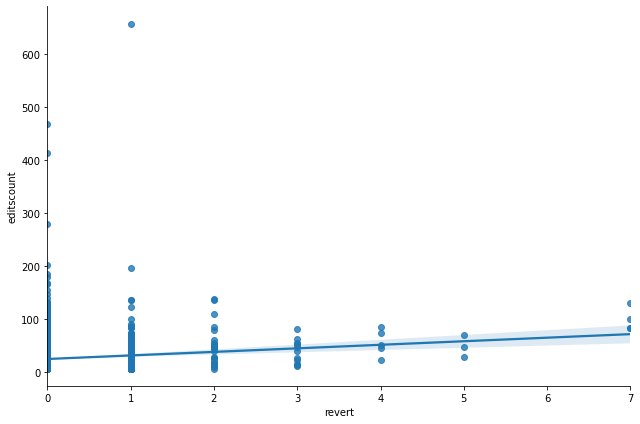

In [55]:
sns.lmplot(x="revert", y="editscount", data=proxies, height=6, aspect=1.5)

In [56]:
corr_matrix = proxies.corr()
corr_matrix

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.019237,0.200114,0.324136,0.105041,0.026025,0.024045,0.279803
merge,0.019237,1.000000,0.032791,0.044425,0.017602,0.024313,-0.036991,0.084213
undo,0.200114,0.032791,1.000000,0.169376,0.087019,-0.002412,-0.026349,0.172882
restore,0.324136,0.044425,0.169376,1.000000,0.142087,0.047286,0.022177,0.179974
protect,0.105041,0.017602,0.087019,0.142087,1.000000,0.005027,0.014779,0.090301
remove,0.026025,0.024313,-0.002412,0.047286,0.005027,1.000000,-0.046370,-0.043306
editscount,0.024045,-0.036991,-0.026349,0.022177,0.014779,-0.046370,1.000000,-0.187066
userscount,0.279803,0.084213,0.172882,0.179974,0.090301,-0.043306,-0.187066,1.000000


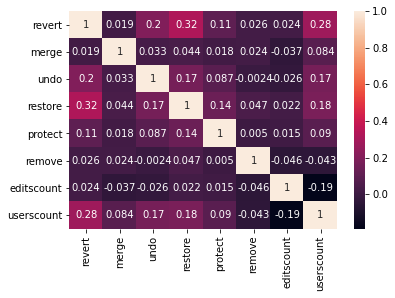

In [57]:
sns.heatmap(corr_matrix, annot=True)

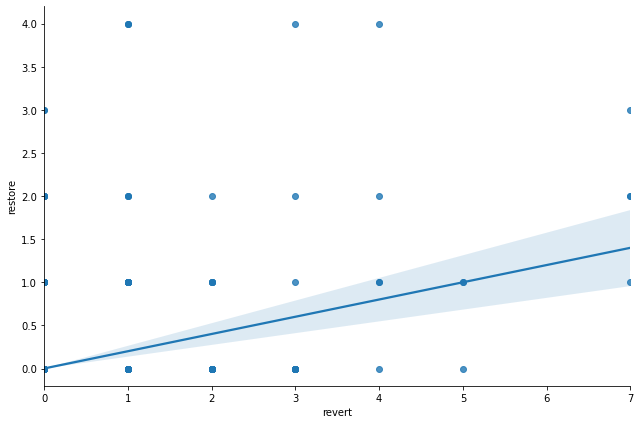

In [58]:
# restore and revert have positive correlation
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

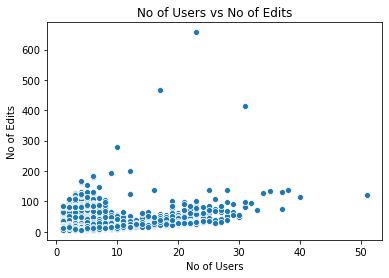

In [59]:
# userscount and editscount have negative correlation 
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

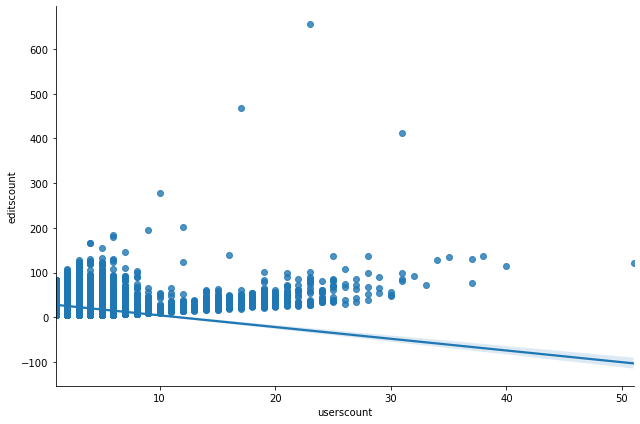

In [60]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=1.5)

In [61]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [62]:
proxies.shape

(19936, 9)

In [63]:
# Items which only have edits under remove and are 0 for the remaining proxies
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
19,Q2132370,0,0,0,0,0,1,12,4
24,Q2135975,0,0,0,0,0,1,7,3
25,Q2137655,0,0,0,0,0,3,17,3
33,Q2142272,0,0,0,0,0,1,7,4
34,Q2142313,0,0,0,0,0,1,36,4
...,...,...,...,...,...,...,...,...,...
100230,Q28050889,0,0,0,0,0,1,8,3
100231,Q28050899,0,0,0,0,0,1,10,3
100232,Q28050911,0,0,0,0,0,1,7,4
100286,Q28057762,0,0,0,0,0,1,13,1


In [64]:
# Removing items with only edits under remove
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [65]:
proxies_without_remove.shape

(2153, 9)

In [66]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.188279,0.005542,0.271162,0.096829,0.072598,0.279141,0.465285
merge,-0.188279,1.000000,-0.547779,-0.118218,-0.007830,0.064170,-0.083118,-0.134946
undo,0.005542,-0.547779,1.000000,0.009264,0.078446,-0.046167,0.049828,0.037946
restore,0.271162,-0.118218,0.009264,1.000000,0.135891,0.142395,0.244105,0.265424
protect,0.096829,-0.007830,0.078446,0.135891,1.000000,0.014008,0.117138,0.171024
remove,0.072598,0.064170,-0.046167,0.142395,0.014008,1.000000,0.624438,0.165501
editscount,0.279141,-0.083118,0.049828,0.244105,0.117138,0.624438,1.000000,0.547922
userscount,0.465285,-0.134946,0.037946,0.265424,0.171024,0.165501,0.547922,1.000000


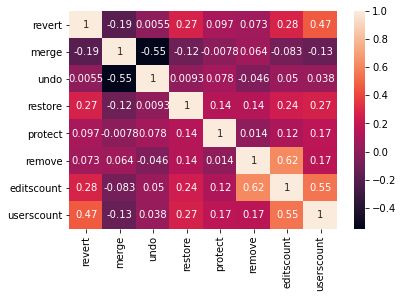

In [67]:
sns.heatmap(corr, annot=True)

# Top 20

## Top 20 Reverts

In [68]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [69]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
2407,Q29,7,0,8,3,0,5,130,37
2435,Q77,7,0,2,2,0,0,82,23
2441,Q96,7,0,4,1,0,4,82,31
2600,Q801,7,0,3,2,0,6,99,28
2498,Q298,5,0,0,1,0,2,70,21
2528,Q513,5,0,2,0,0,4,46,20
3415,Q9202,5,0,2,1,0,0,28,14
2440,Q90,4,0,0,2,0,4,51,28
2517,Q419,4,0,0,1,0,0,74,23
2569,Q717,4,0,4,4,0,2,85,27


In [70]:
revert_item_labels = ['Spain', 'Uruguay', 'Mexico', 'Israel', 'Chile',
                     'Mount Everest', 'Statue of Liberty', 'Paris', 'Peru', 'Venezuela', 
                     'Madrid', 'Penghu Islands', 'Eiffel Tower', 'Armenia', 'Argentina', 
                     'Colombia', 'Buenos Aires', 'Bogotá', 'Taj Mahal', 'White House']

# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [71]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
2407,Q29,Spain,7,0,8,3,0,5,130,37
2435,Q77,Uruguay,7,0,2,2,0,0,82,23
2441,Q96,Mexico,7,0,4,1,0,4,82,31
2600,Q801,Israel,7,0,3,2,0,6,99,28
2498,Q298,Chile,5,0,0,1,0,2,70,21
2528,Q513,Mount Everest,5,0,2,0,0,4,46,20
3415,Q9202,Statue of Liberty,5,0,2,1,0,0,28,14
2440,Q90,Paris,4,0,0,2,0,4,51,28
2517,Q419,Peru,4,0,0,1,0,0,74,23
2569,Q717,Venezuela,4,0,4,4,0,2,85,27


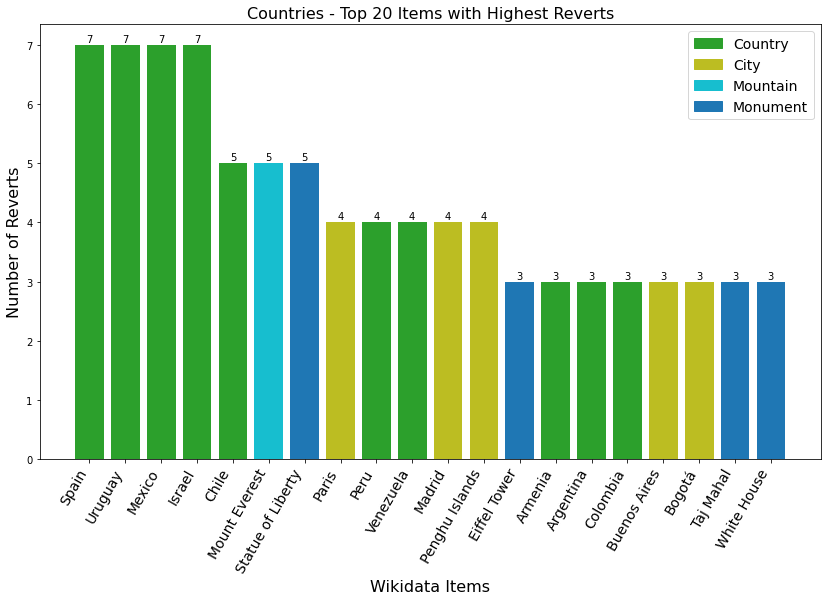

In [80]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

colours = ['tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:green',
           'tab:cyan', 'tab:blue', 'tab:olive', 'tab:green', 'tab:green',
           'tab:olive', 'tab:olive', 'tab:blue', 'tab:green', 'tab:green',
           'tab:green', 'tab:olive', 'tab:olive', 'tab:blue', 'tab:blue']

country = mpatches.Patch(color='tab:green', label='Country')
city = mpatches.Patch(color='tab:olive', label='City')
mountain = mpatches.Patch(color='tab:cyan', label='Mountain')
monument = mpatches.Patch(color='tab:blue', label='Monument')

plt.legend(handles=[country, city, mountain, monument], fontsize=14)

plt.bar(top20_reverts['label'], top20_reverts['revert'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("Countries - Top 20 Items with Highest Reverts", fontsize=16)
plt.show()

## Top 20 Merges

In [72]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [73]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
60238,Q1818778,0,3,0,0,0,14,28,8
1746,Q2604568,1,2,0,0,0,0,6,3
2843,Q1865,0,2,0,0,0,0,26,19
3231,Q5869,0,2,0,0,0,2,18,11
6736,Q64224,0,2,0,0,0,2,12,6
9156,Q164536,0,2,0,0,0,3,22,7
19631,Q1420577,0,2,1,0,0,23,49,3
23510,Q4879016,0,2,0,0,0,2,6,2
27823,Q12816326,0,2,0,0,0,0,10,2
36774,Q25247843,0,2,0,0,0,1,7,4


In [74]:
merge_item_labels = ['Tultepec', 'Nagarote ', 'Kuala Lumpur', 'Lhasa', 'Opfikon',
                     'Frymburk', 'Caldera de Taburiente', 'Beddawi', 'Szokolya', 'Ghatail', 
                     'Červená', 'Valle de Abdalajís', 'Haddhunmathi Atoll', 'Teocaltiche', 'Tío Pujio', 
                     'Villa Concepción del Tío', 'Březová', 'Rusová', 'Jesenice', 'Kingdom of Norway (872–1397) ']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [75]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
60238,Q1818778,Tultepec,0,3,0,0,0,14,28,8
1746,Q2604568,Nagarote,1,2,0,0,0,0,6,3
2843,Q1865,Kuala Lumpur,0,2,0,0,0,0,26,19
3231,Q5869,Lhasa,0,2,0,0,0,2,18,11
6736,Q64224,Opfikon,0,2,0,0,0,2,12,6
9156,Q164536,Frymburk,0,2,0,0,0,3,22,7
19631,Q1420577,Caldera de Taburiente,0,2,1,0,0,23,49,3
23510,Q4879016,Beddawi,0,2,0,0,0,2,6,2
27823,Q12816326,Szokolya,0,2,0,0,0,0,10,2
36774,Q25247843,Ghatail,0,2,0,0,0,1,7,4


Text(0.5, 1.0, 'Countries - Top 20 Items with Highest Merges')

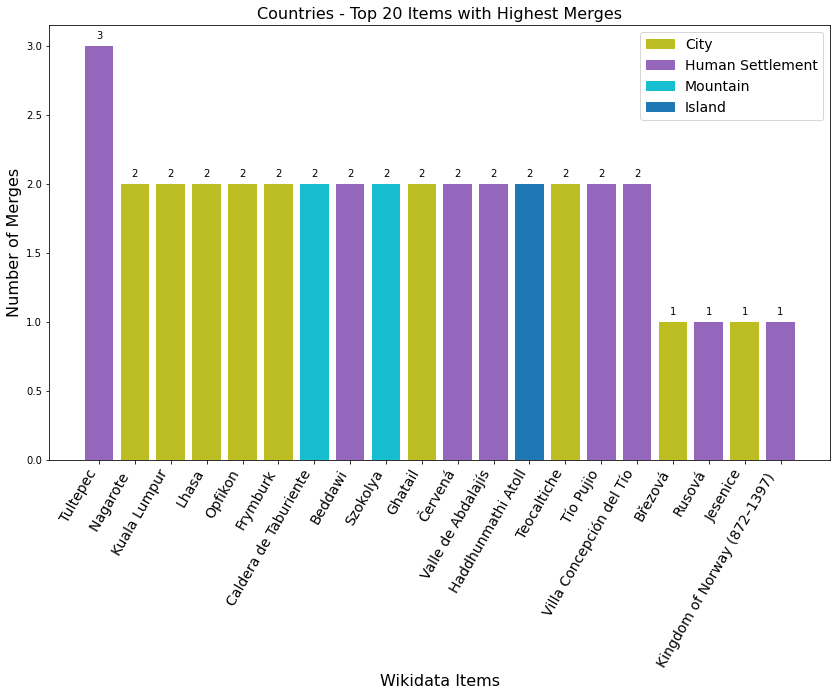

In [77]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    

colours = ['tab:purple', 'tab:olive', 'tab:olive', 'tab:olive', 'tab:olive',
           'tab:olive', 'tab:cyan', 'tab:purple', 'tab:cyan', 'tab:olive',
           'tab:purple', 'tab:purple', 'tab:blue', 'tab:olive', 'tab:purple',
           'tab:purple', 'tab:olive', 'tab:purple', 'tab:olive', 'tab:purple']

city = mpatches.Patch(color='tab:olive', label='City')
human_settlement = mpatches.Patch(color='tab:purple', label='Human Settlement')
mountain = mpatches.Patch(color='tab:cyan', label='Mountain')
island = mpatches.Patch(color='tab:blue', label='Island')

plt.legend(handles=[city, human_settlement, mountain, island], fontsize=14)

plt.bar(top20_merges['label'], top20_merges['merge'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("Countries - Top 20 Items with Highest Merges", fontsize=16)

## Top 20 Undos

In [78]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [79]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
2407,Q29,7,0,8,3,0,5,130,37
2408,Q30,1,1,6,4,1,5,122,51
2453,Q183,0,0,5,0,0,14,115,40
23388,Q4795478,1,0,5,0,0,0,8,3
1436,Q2514944,0,0,4,0,0,0,10,2
2441,Q96,7,0,4,1,0,4,82,31
2479,Q235,1,0,4,0,0,3,38,16
2569,Q717,4,0,4,4,0,2,85,27
2931,Q2807,4,0,4,1,0,0,45,24
5498,Q33613,0,0,4,0,0,0,24,6


In [80]:
undo_item_labels = ['Spain', 'United States of America', 'Germany', 'Aroer', 'Bacup',
                     'Mexico', 'Monaco', 'Venezuela', 'Madrid', 'Kramatorsk', 
                     'Carnforth', 'Skelmersdale', 'Colchester', 'Lytham St Annes', 'Republic of Ireland', 
                     'France', 'Russia', 'Israel', 'Syria', 'Beckum']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

In [81]:
top20_undos

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
2407,Q29,Spain,7,0,8,3,0,5,130,37
2408,Q30,United States of America,1,1,6,4,1,5,122,51
2453,Q183,Germany,0,0,5,0,0,14,115,40
23388,Q4795478,Aroer,1,0,5,0,0,0,8,3
1436,Q2514944,Bacup,0,0,4,0,0,0,10,2
2441,Q96,Mexico,7,0,4,1,0,4,82,31
2479,Q235,Monaco,1,0,4,0,0,3,38,16
2569,Q717,Venezuela,4,0,4,4,0,2,85,27
2931,Q2807,Madrid,4,0,4,1,0,0,45,24
5498,Q33613,Kramatorsk,0,0,4,0,0,0,24,6


Text(0.5, 1.0, 'Countries - Top 20 Items with Highest Undos')

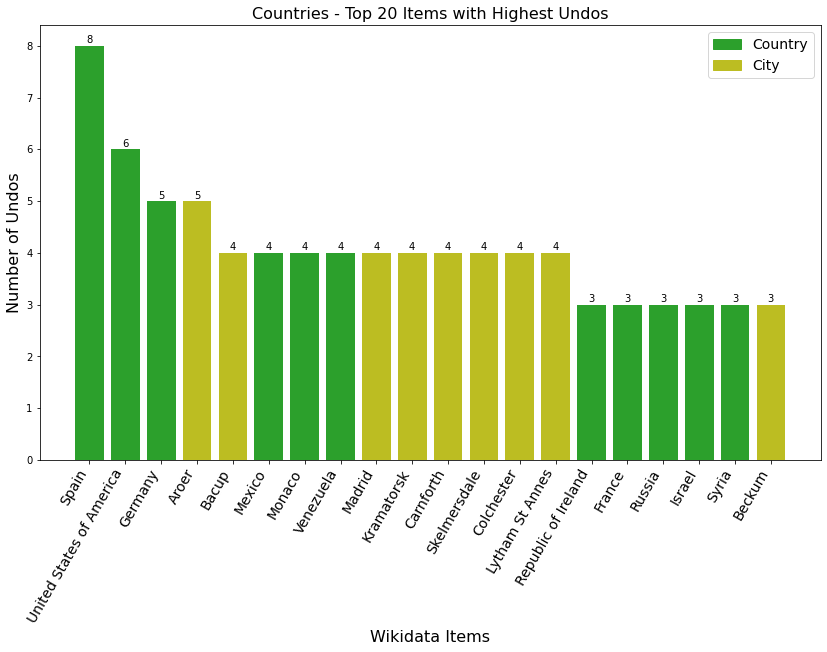

In [82]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    
colours = ['tab:green', 'tab:green', 'tab:green', 'tab:olive', 'tab:olive',
           'tab:green', 'tab:green', 'tab:green', 'tab:olive', 'tab:olive',
           'tab:olive', 'tab:olive', 'tab:olive', 'tab:olive', 'tab:green',
           'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:olive']

country = mpatches.Patch(color='tab:green', label='Country')
city = mpatches.Patch(color='tab:olive', label='City')

plt.legend(handles=[country, city], fontsize=14)

plt.bar(top20_undos['label'], top20_undos['undo'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Undos", fontsize=16)
plt.title("Countries - Top 20 Items with Highest Undos", fontsize=16)

## Top 20 Restores

In [83]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [84]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
2408,Q30,1,1,6,4,1,5,122,51
2516,Q414,3,0,0,4,0,3,80,24
2569,Q717,4,0,4,4,0,2,85,27
3375,Q8385,1,0,0,4,0,38,195,9
9421,Q174684,1,0,3,4,0,0,32,16
2407,Q29,7,0,8,3,0,5,130,37
9041,Q158119,0,0,3,3,0,2,31,17
27380,Q12031431,0,0,0,3,0,0,8,3
2435,Q77,7,0,2,2,0,0,82,23
2440,Q90,4,0,0,2,0,4,51,28


In [85]:
restore_item_labels = ['United States of America', 'Argentina', 'Venezuela', 'Ostrava', 'Tuzla',
                     'Spain', 'Ramallah', 'Krasovice', 'Uruguay', 'Paris', 
                     'Russia', 'Colombia', 'Israel', 'Hamburg', 'Manila', 
                     'Tokyo', 'Barcelona', 'Catalonia', 'Castro Urdiales', 'Wittlich']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

In [86]:
top20_restores

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
2408,Q30,United States of America,1,1,6,4,1,5,122,51
2516,Q414,Argentina,3,0,0,4,0,3,80,24
2569,Q717,Venezuela,4,0,4,4,0,2,85,27
3375,Q8385,Ostrava,1,0,0,4,0,38,195,9
9421,Q174684,Tuzla,1,0,3,4,0,0,32,16
2407,Q29,Spain,7,0,8,3,0,5,130,37
9041,Q158119,Ramallah,0,0,3,3,0,2,31,17
27380,Q12031431,Krasovice,0,0,0,3,0,0,8,3
2435,Q77,Uruguay,7,0,2,2,0,0,82,23
2440,Q90,Paris,4,0,0,2,0,4,51,28


Text(0.5, 1.0, 'Countries - Top 20 Items with Highest Restores')

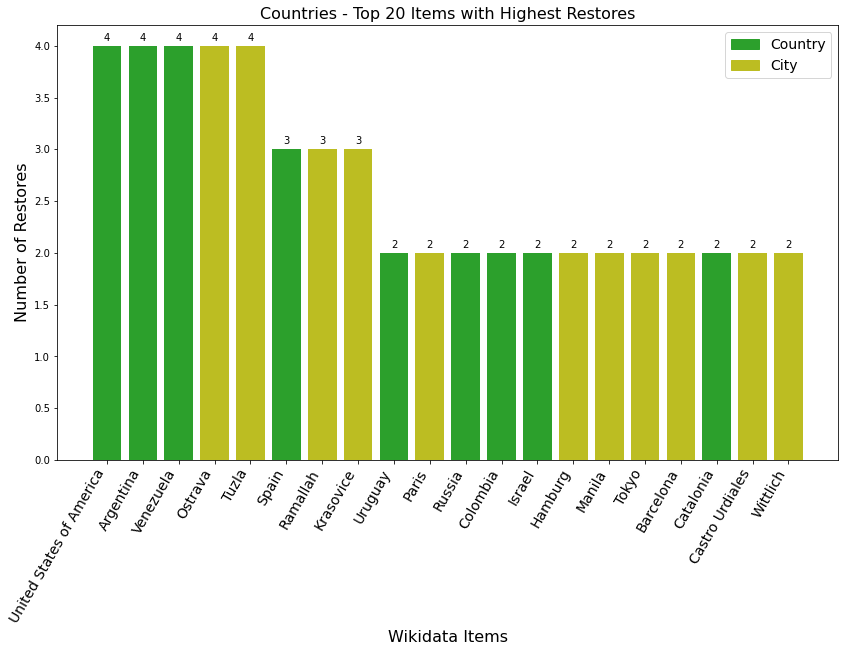

In [88]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

    
colours = ['tab:green', 'tab:green', 'tab:green', 'tab:olive', 'tab:olive',
           'tab:green', 'tab:olive', 'tab:olive', 'tab:green', 'tab:olive',
           'tab:green', 'tab:green', 'tab:green', 'tab:olive', 'tab:olive',
           'tab:olive', 'tab:olive', 'tab:green', 'tab:olive', 'tab:olive']

country = mpatches.Patch(color='tab:green', label='Country')
city = mpatches.Patch(color='tab:olive', label='City')

plt.legend(handles=[country, city], fontsize=14)

plt.bar(top20_restores['label'], top20_restores['restore'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("Countries - Top 20 Items with Highest Restores", fontsize=16)

## Top 20 Edits

In [89]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [90]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
2709,Q1085,1,0,0,1,0,137,657,23
2551,Q656,0,0,1,0,0,7,413,31
3668,Q14960,0,0,1,0,0,59,279,10
3375,Q8385,1,0,0,4,0,38,195,9
46267,Q756617,0,1,2,0,0,9,139,16
2446,Q142,2,0,3,0,0,5,137,38
2450,Q159,1,0,3,2,0,7,136,28
2476,Q230,1,0,0,0,0,7,136,25
2426,Q55,2,0,0,1,0,8,135,35
2407,Q29,7,0,8,3,0,5,130,37


In [91]:
edit_item_labels = ['Prague', 'Saint Petersburg', 'Brno', 'Ostrava', 'Kingdom of Denmark',
                     'France', 'Russia', 'Georgia', 'Netherlands', 'Spain', 
                     'Denmark', 'United States of America', 'Germany', 'Saudi Arabia', 'Hong Kong',  
                     'Albania', 'India', 'Israel', 'Gennes-Val de Loire ', 'Poland']

# Inserting item labels into edit proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

In [92]:
top20_edits

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
2709,Q1085,Prague,1,0,0,1,0,137,657,23
2551,Q656,Saint Petersburg,0,0,1,0,0,7,413,31
3668,Q14960,Brno,0,0,1,0,0,59,279,10
3375,Q8385,Ostrava,1,0,0,4,0,38,195,9
46267,Q756617,Kingdom of Denmark,0,1,2,0,0,9,139,16
2446,Q142,France,2,0,3,0,0,5,137,38
2450,Q159,Russia,1,0,3,2,0,7,136,28
2476,Q230,Georgia,1,0,0,0,0,7,136,25
2426,Q55,Netherlands,2,0,0,1,0,8,135,35
2407,Q29,Spain,7,0,8,3,0,5,130,37


Text(0.5, 1.0, 'Countries - Top 20 Items with Highest Edits')

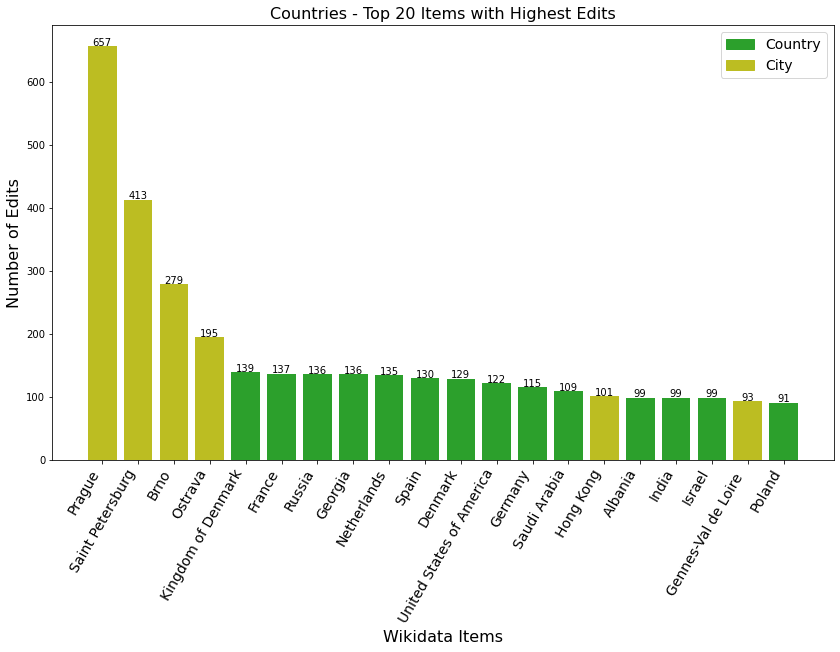

In [94]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')


colours = ['tab:olive', 'tab:olive', 'tab:olive', 'tab:olive', 'tab:green',
           'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:green',
           'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:olive',
           'tab:green', 'tab:green', 'tab:green', 'tab:olive', 'tab:green']

country = mpatches.Patch(color='tab:green', label='Country')
city = mpatches.Patch(color='tab:olive', label='City')

plt.legend(handles=[country, city], fontsize=14)

plt.bar(top20_edits['label'], top20_edits['editscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("Countries - Top 20 Items with Highest Edits", fontsize=16)

## Top 20 Users

In [95]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [96]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
2408,Q30,1,1,6,4,1,5,122,51
2453,Q183,0,0,5,0,0,14,115,40
2446,Q142,2,0,3,0,0,5,137,38
2407,Q29,7,0,8,3,0,5,130,37
2426,Q55,2,0,0,1,0,8,135,35
2413,Q35,0,1,2,1,0,74,129,34
2448,Q148,1,0,1,0,0,3,71,33
2401,Q17,2,0,2,0,0,5,85,31
2441,Q96,7,0,4,1,0,4,82,31
2551,Q656,0,0,1,0,0,7,413,31


In [97]:
user_item_labels = ['United States of America', 'Germany', 'France', 'Spain', 'Netherlands',
                     'Denmark', 'People\'s Republic of China', 'Japan', 'Mexico', 'Saint Petersburg', 
                     'India', 'New York City', 'Bengaluru', 'Tokyo', 'Turkey',  
                     'Cyprus', 'United Arab Emirates', 'Paris', 'Russia', 'Israel']

# Inserting item labels into user proxies dataframe
top20_users.insert(1, "label", user_item_labels, True)

In [98]:
top20_users

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
2408,Q30,United States of America,1,1,6,4,1,5,122,51
2453,Q183,Germany,0,0,5,0,0,14,115,40
2446,Q142,France,2,0,3,0,0,5,137,38
2407,Q29,Spain,7,0,8,3,0,5,130,37
2426,Q55,Netherlands,2,0,0,1,0,8,135,35
2413,Q35,Denmark,0,1,2,1,0,74,129,34
2448,Q148,People's Republic of China,1,0,1,0,0,3,71,33
2401,Q17,Japan,2,0,2,0,0,5,85,31
2441,Q96,Mexico,7,0,4,1,0,4,82,31
2551,Q656,Saint Petersburg,0,0,1,0,0,7,413,31


Text(0.5, 1.0, 'Countries - Top 20 Items with Highest Users')

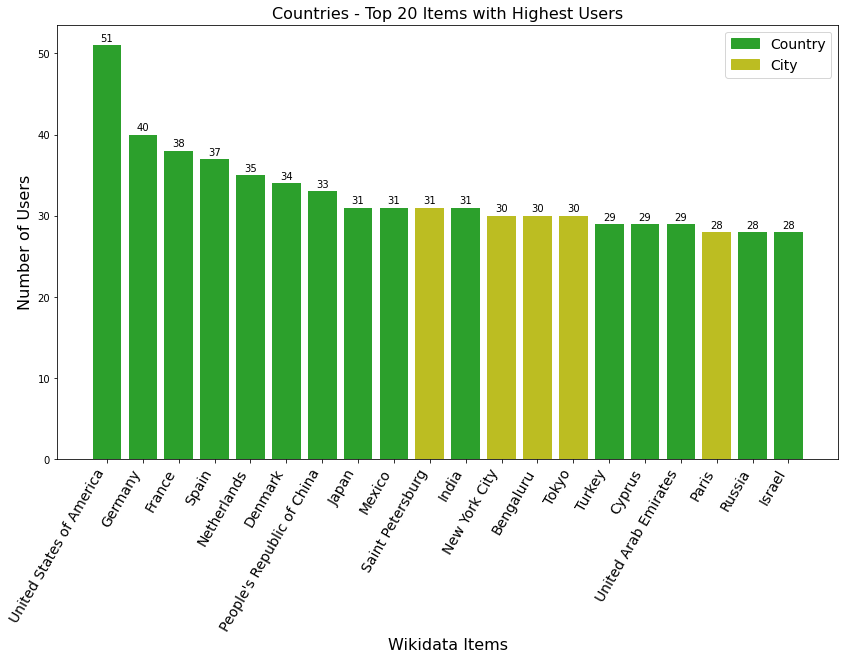

In [100]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')


colours = ['tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:green',
           'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:olive',
           'tab:green', 'tab:olive', 'tab:olive', 'tab:olive', 'tab:green',
           'tab:green', 'tab:green', 'tab:olive', 'tab:green', 'tab:green']

country = mpatches.Patch(color='tab:green', label='Country')
city = mpatches.Patch(color='tab:olive', label='City')

plt.legend(handles=[country, city], fontsize=14)

plt.bar(top20_users['label'], top20_users['userscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("Countries - Top 20 Items with Highest Users", fontsize=16)

# Selecting Specific Items

In [101]:
# Finding most commonly occurring items in proxies revert, merge, restore and undo
data_frames = [top20_reverts, top20_merges, top20_undos, top20_restores, top20_edits, top20_users]
common_items = pd.concat(data_frames)

In [102]:
common_items_count = common_items['qid'].value_counts()
common_20 = common_items_count.nlargest(20)
print("Items and the number of times they occurred in top 20 reverts, merges, restores and undos")
print(common_20)

Items and the number of times they occurred in top 20 reverts, merges, restores and undos
Q29          5
Q801         5
Q159         4
Q30          4
Q96          3
Q90          3
Q717         3
Q183         3
Q142         3
Q1490        2
Q77          2
Q35          2
Q2807        2
Q668         2
Q8385        2
Q739         2
Q656         2
Q55          2
Q414         2
Q12031431    1
Name: qid, dtype: int64


Based on the above information and using assumption-3 that items with a diverse range of proxies would be interesting to look at, the following items were selecetd.

- Israel Q801
- Spain Q29
- Russia Q159
- USA Q30
- Mexico Q96 
- Venezuela Q717

In [103]:
# Storing the revisions of the selected items in CSV files
# rev[rev['qid'] == 'Q801'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/countries/Israel_Q801.csv')
# rev[rev['qid'] == 'Q29'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/countries/Spain_Q29.csv')
# rev[rev['qid'] == 'Q159'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/countries/Russia_Q159.csv')
# rev[rev['qid'] == 'Q30'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/countries/USA_Q30.csv')
# rev[rev['qid'] == 'Q96'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/countries/Mexico_Q96.csv')
# rev[rev['qid'] == 'Q717'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/countries/Venezuela_Q717.csv')